In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pickle

Función de posición

In [ ]:
# funcion secundaria encontrar la posición de la incidencia de un muon 
def conteo(res, evento, n_counts, range_can): # imagen (x,y), el evento a revisar, cantidad de conteos totales, rango de canales activados
    
    n = len(evento) # cantidad de canales activados en el evento
    lix = [i for i in evento if i <= 28] # canales 0-28
    liy = [i for i in evento if i >= 32 and i <= 60] # canales 32-60
    
    # Discrimina rondas con cuadruples y que esten juntos cada pareja
    if len(lix) in range_can[0] and len(liy) in range_can[1] and len(lix)+len(liy)!=2:
        
        # Se hace un subdiccionario para los dos ejes y dos listas para la diferencia de indice entre
        # los canales adyacentes para discriminar si son contiguos: la suma debe dar la cantidad de canales -1
        x = {}
        y = {}
        difx = []
        dify = []
        ant = 0
        for llave, valor in evento.items():
            if llave <= 28:
                x[llave] = valor
                if len(x) >= 2:
                    difx.append(llave - ant)
            elif llave >= 32 and llave <= 60:
                y[llave] = valor
                if len(y) >= 2:
                    dify.append(llave - ant)
                
            ant = llave
        
        # Discrimina si son contiguos: la suma debe dar la cantidad de canales -1
        if sum(difx) == len(x)-1 and sum(dify) == len(y)-1:
            
            # Se suman los el producto de la posición del canal (#canal*2cm) y la carga asociada
            # y se divide por la cantidad de canales del evento
            
            carga_x = np.array(list(x.values()))
            carga_y = np.array(list(y.values()))
            pos_x = sum(carga_x * (np.array(list(x.keys())) + 1) * 2) / sum(carga_x) # sumar 1 para que el canal 0 sea 2cm
            pos_y = sum(carga_y * (np.array(list(y.keys())) - 31) * 2) / sum(carga_y) # restar 31 para que el canal 32 sea 2cm
            
            carga = sum(carga_x) + sum(carga_y)
            val = [pos_x, pos_y,carga]
            res = np.vstack([res,val])

            n_counts.append(n)
            
            
            
            return res, n_counts

        else:
            return None
    else:
        return None


def resolucion(df_boss, df_sub, range_can, td_hg):
    # respuesta imagen (x,y,carga)
    res_b = np.empty((0, 3))
    res_s = np.empty((0, 3))
    
    # Lista de cantidad de canales activados por disparo con HG y LG
    n_counts_b= [] 
    n_counts_s= [] 
    
    # Conteos totales por disparo {Núm.canales:contador}
    conteo_total_b = {}
    conteo_total_s = {}

    # Se llenan los disccionarios
    for i in range(65):
        conteo_total_b[i] = 0
        conteo_total_s[i] = 0
    
    # Recorre cada ronda de activación - i-ésima ronda
    for i in range(int(min(len(df_boss)/64, len(df_sub)/64))):
        
        # Lista de los canales activos para aquellos discriminados en funcion de el HG, LG o b-ambos
        bg_event = {}
        sg_event = {}
        
        # Recorre todos los canales de la ronda de activación - j-ésimo canal de la i-ésimo disparo
        for j in range(64):
            
            # Valor del H/L gain
            bg = df_boss["HG"].values[i*64 + j]
            sg = df_sub["HG"].values[i*64 + j]

            # Discrimina y agrega el canal a la lista de canales activados
            if bg > td_hg:
                bg_event[j] = bg
            if sg > td_hg:
                sg_event[j] = sg
        
        # Agrega cantidad de canales activados en el disparo
        conteo_total_b[len(bg_event)] += 1
        conteo_total_s[len(sg_event)] += 1
        
        conteo_total = [conteo_total_b,conteo_total_s]
        
        con_b = conteo(res_b, bg_event, n_counts_b, range_can)
        con_s = conteo(res_s, sg_event, n_counts_s, range_can)
        
        
        
        if con_b is not None and con_s is not None:
            res_b, n_counts_b = con_b
            res_s, n_counts_s = con_s
            
        

    datos_b = res_b, n_counts_b
    datos_s = res_s, n_counts_s     
    
    return datos_b, datos_s, conteo_total

calculo para los archivos con toma tipo acople dual

In [3]:
td_hg = 1000
range_can = [[2],[2]]
df_boss = pd.read_parquet('Datos\Toma_Hodoscopio\Toma_lider\Toma_datos_1h.parquet', engine='pyarrow')
df_sub = pd.read_parquet('Datos\Toma_Hodoscopio\Toma_sub\Toma_datos_1h.parquet', engine='pyarrow')

total_4 = resolucion(df_boss, df_sub, range_can, td_hg)
with open("Datos\Toma_Hodoscopio\Resolucion.pkl", "wb") as f:
    pickle.dump(total_4, f)

range_can = [[1,2],[1,2]]
total_34 = resolucion(df_boss, df_sub, range_can, td_hg)
with open("Datos\Toma_Hodoscopio\Resolucion34.pkl", "wb") as f:
    pickle.dump(total_34, f)

In [2]:
with open("Datos\Toma_Hodoscopio_1m\Toma_15h\Resolucion34.pkl", "rb") as f:
    total = pickle.load(f)

datos_b, datos_s, conteo_total = total
res_b, n_counts_b = datos_b
res_s, n_counts_s = datos_s
conteo_total_b, conteo_total_s = conteo_total

Calculo de matriz de calor

In [ ]:
xb = res_b[:,0]
yb = res_b[:,1]
carb = res_b[:,2]

# Eventos toma sin plomo
xs = res_s[:,0]
ys = res_s[:,1]
cars = res_s[:,2]  

# Cantidad de bins
bins = 30 # Cantidad de bins por eje
bin_size = 60/bins # Tamaño por eje 60cm

# Grilla
x0 = np.linspace(0, 60, bins+1)
y0 = np.linspace(0, 60, bins+1)

# Inicializar la matriz de conteo
matriz_res_b = np.zeros((bins+1, bins+1))
matriz_con_b = np.zeros((bins+1, bins+1))

matriz_res_s = np.zeros((bins+1, bins+1))
matriz_con_s = np.zeros((bins+1, bins+1))

# Clasificar manualmente cada punto (x, y) por el indice de su bin (discretización)
for k in range(int(min(len(xb), len(xs)))):
    bi = int(round(xb[k]/bin_size,0))
    bj = int(round(yb[k]/bin_size,0))
    
    matriz_con_b[bi, bj] += 1
    matriz_res_b[bi, bj] += carb[k]
    
    si = int(round(xs[k]/bin_size,0))
    sj = int(round(ys[k]/bin_size,0))
    
    matriz_con_s[si, sj] += 1
    matriz_res_s[si, sj] += cars[k]
    
err_matriz_con_b = np.sqrt(matriz_con_b)
err_matriz_con_s = np.sqrt(matriz_con_s)

grafico de calor para la subdito

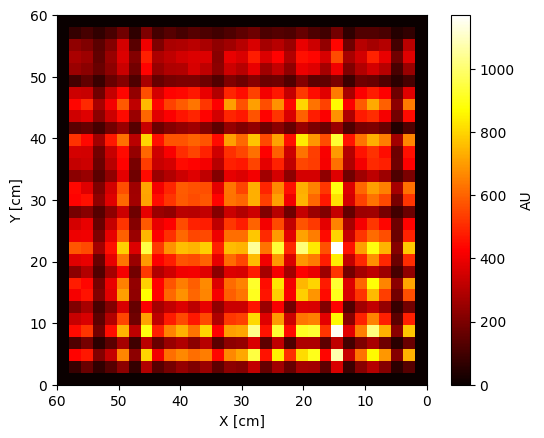

In [26]:
from matplotlib.colors import LogNorm
#, clim=(0.5,1.5) , norm=LogNorm(vmin=0.5, vmax=1.5)

plt.imshow(matriz_con_s[::-1, ::-1].T, extent=[60,0,0,60], cmap="hot")
plt.colorbar(label='AU')
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')

plt.show()

Distancia coordenadas "x" y "y" Scipy-norm

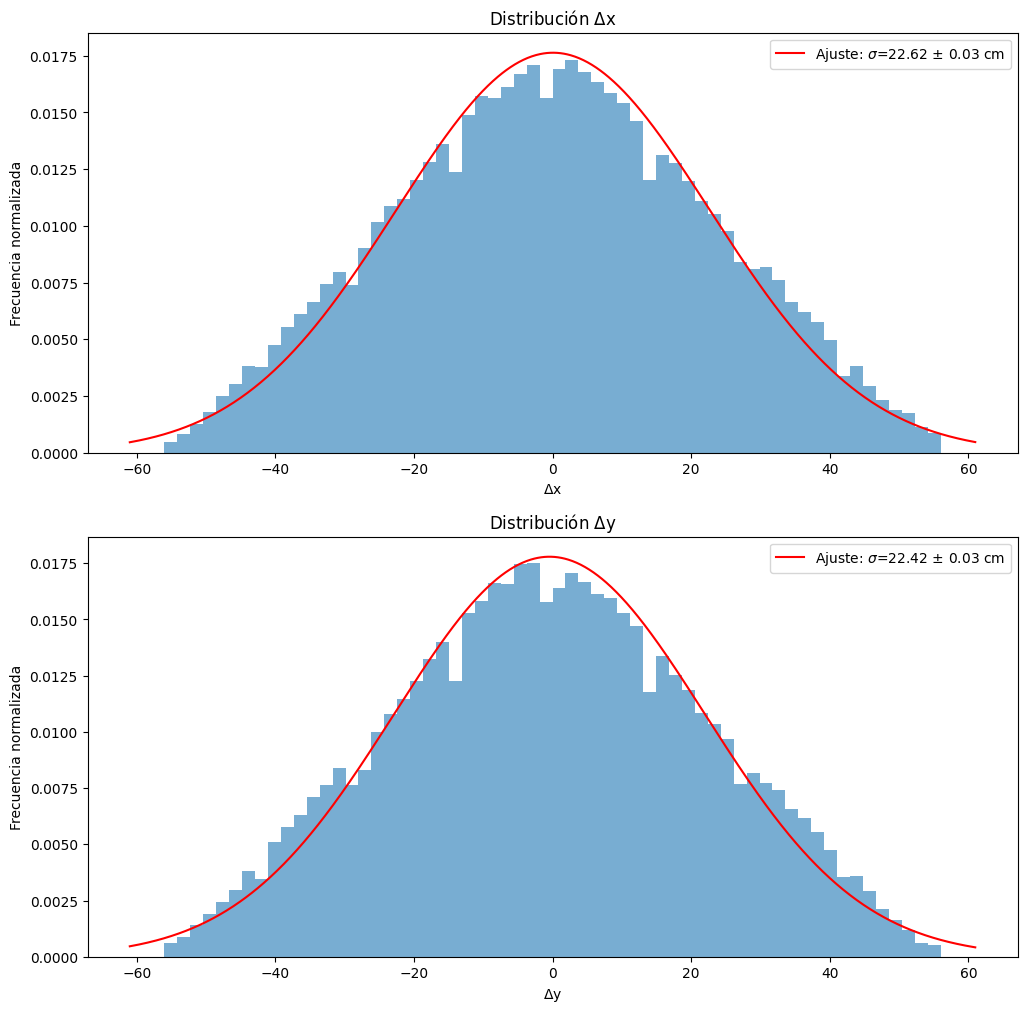

In [ ]:
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.stats import norm

# Pos x y y para ambas matrices con su error (poisson)
xb = res_b[:,0]
yb = res_b[:,1]
err_xb = np.sqrt(xb)
err_yb = np.sqrt(yb)

xs = res_s[:,0]
ys = res_s[:,1]
err_xs = np.sqrt(xs)
err_ys = np.sqrt(ys)

# Distancia entre coordenadas "x" y "y"
resx = xb - xs
resy = yb - ys

err_resx = np.sqrt(err_xb**2 + err_xs**2)
err_resy = np.sqrt(err_yb**2 + err_ys**2)

x_mu_fit, x_sigma_fit = norm.fit(resx)
y_mu_fit, y_sigma_fit = norm.fit(resy)

# La incertidumbre de los parámetros ajustados (desviación estándar)
x_sigma_error = x_sigma_fit / np.sqrt(2 * len(resx))
y_sigma_error = y_sigma_fit / np.sqrt(2 * len(resy))

x0_fit = np.linspace(min(resx)-5, max(resx)+5, 1000)
y0_fit = np.linspace(min(resy)-5, max(resy)+5, 1000)

x_fit = norm.pdf(x0_fit, x_mu_fit, x_sigma_fit)
y_fit = norm.pdf(y0_fit, y_mu_fit, y_sigma_fit)

fig1, ax1 = plt.subplots(2, 1, figsize=(12, 12))

bins = 60
ax1[0].hist(resx, bins=bins, density=True, alpha=0.6)
ax1[0].plot(x0_fit, x_fit, color = "red", label=f'Ajuste: $\sigma$={x_sigma_fit:.2f} $\pm$ {round(x_sigma_error,2)} cm')
ax1[0].set_xlabel(f"$\Delta$x")
ax1[0].set_ylabel("Frecuencia normalizada")
ax1[0].set_title("Distribución $\Delta$x")
ax1[0].legend()

ax1[1].hist(resy, bins=bins, density=True, alpha=0.6)
ax1[1].plot(y0_fit, y_fit, color="red", label=f'Ajuste: $\sigma$={y_sigma_fit:.2f} $\pm$ {round(y_sigma_error,2)} cm')
ax1[1].set_xlabel(f"$\Delta$y")
ax1[1].set_ylabel("Frecuencia normalizada")
ax1[1].set_title("Distribución $\Delta$y")
ax1[1].legend()


Distancia coordenadas "x" y "y" Fit manual - curve_fit

array([1.64251676e-02, 4.84812657e-01, 2.48951546e+01])

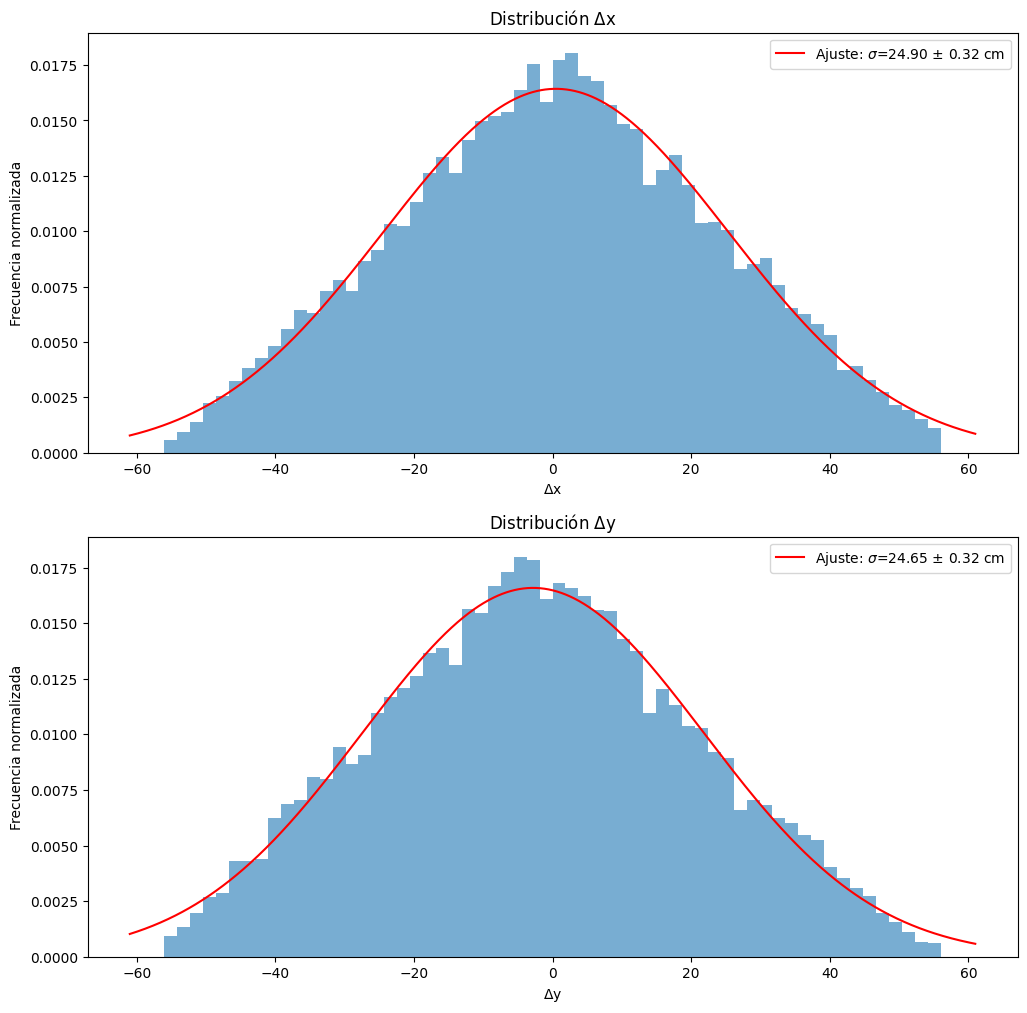

In [4]:
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.stats import norm

xb = res_b[:,0]
yb = res_b[:,1]
err_xb = np.sqrt(xb)
err_yb = np.sqrt(yb)

xs = res_s[:,0]
ys = res_s[:,1]
err_xs = np.sqrt(xs)
err_ys = np.sqrt(ys)

resx = xb - xs
resy = yb - ys


filtro = 60
resx = resx[ (resx >= -filtro) & (resx <= filtro)]
resy = resy[(resy >= -filtro) & (resy <= filtro)]

err_resx = np.sqrt(err_xb**2 + err_xs**2)
err_resy = np.sqrt(err_yb**2 + err_ys**2)

def gauss(x, A, mu, sigma):
    return A * np.exp(-(x - mu)**2 / (2 * sigma**2))

bins = 60

xfrequencies, xbin_edges = np.histogram(resx, bins=bins, density=True)
xbin_centers = (xbin_edges[:-1] + xbin_edges[1:]) / 2

yfrequencies, ybin_edges = np.histogram(resy, bins=bins, density=True)
ybin_centers = (ybin_edges[:-1] + ybin_edges[1:]) / 2

xinitial_guess = [max(xfrequencies), np.mean(resx), np.std(resx)]
yinitial_guess = [max(yfrequencies), np.mean(resy), np.std(resy)]

x_popt, xpcov = curve_fit(gauss, xbin_centers, xfrequencies, p0=xinitial_guess)
y_popt, ypcov = curve_fit(gauss, ybin_centers, yfrequencies, p0=yinitial_guess)

x_A_fit, x_mu_fit, x_sigma_fit = x_popt
y_A_fit, y_mu_fit, y_sigma_fit = y_popt

xperr = np.sqrt(np.diag(xpcov))
yperr = np.sqrt(np.diag(ypcov))

# El error de sigma es el valor de la diagonal correspondiente a sigma
x_sigma_error = xperr[2]
y_sigma_error = yperr[2]

x0_fit = np.linspace(min(resx)-5, max(resx)+5, 1000)
y0_fit = np.linspace(min(resy)-5, max(resy)+5, 1000)

x_fit = gauss(x0_fit, x_A_fit, x_mu_fit, x_sigma_fit)
y_fit = gauss(y0_fit, y_A_fit, y_mu_fit, y_sigma_fit)

fig1, ax1 = plt.subplots(2, 1, figsize=(12, 12))

bins = 60
ax1[0].hist(resx, bins=bins, density=True, alpha=0.6)
ax1[0].plot(x0_fit, x_fit, color = "red", label=f'Ajuste: $\sigma$={x_sigma_fit:.2f} $\pm$ {round(x_sigma_error,2)} cm')
ax1[0].set_xlabel(f"$\Delta$x")
ax1[0].set_ylabel("Frecuencia normalizada")
ax1[0].set_title("Distribución $\Delta$x")
ax1[0].legend()

ax1[1].hist(resy, bins=bins, density=True, alpha=0.6)
ax1[1].plot(y0_fit, y_fit, color="red", label=f'Ajuste: $\sigma$={y_sigma_fit:.2f} $\pm$ {round(y_sigma_error,2)} cm')
ax1[1].set_xlabel(f"$\Delta$y")
ax1[1].set_ylabel("Frecuencia normalizada")
ax1[1].set_title("Distribución $\Delta$y")
ax1[1].legend()

x_popt

Estadística de error

In [99]:
resolucion_x = x_sigma_fit/np.sqrt(2)
resolucion_y = y_sigma_fit/np.sqrt(2)

err_resolucion_x = x_sigma_error/np.sqrt(2)
err_resolucion_y = y_sigma_error/np.sqrt(2)

resolucion_x, err_resolucion_x, resolucion_y, err_resolucion_y

(6.812374027736951, 0.2292228530156553, 4.903674970017498, 0.2341950624530147)

Caluclo de distribución de angulos

In [1]:
from scipy.optimize import curve_fit
from scipy.special import erf
from scipy.stats import norm

h = 13 # altura
xb = res_b[:,0]
yb = res_b[:,1]
err_xb = np.sqrt(xb)
err_yb = np.sqrt(yb)

xs = res_s[:,0]
ys = res_s[:,1]
err_xs = np.sqrt(xs)
err_ys = np.sqrt(ys)

resx = xb - xs 
resy = yb - ys 
err_resx = np.sqrt(err_xb**2 + err_xs**2)
err_resy = np.sqrt(err_yb**2 + err_ys**2)

# Cálculo de los ángulos cenital y azimutal
cenit = np.arctan(np.sqrt(resx**2 + resy**2)/h)
azimuth = np.arctan(resy/resx)

# Fit angulo cenital - no funciona así que no lo grafico
def func(theta, A):
    return A* np.cos(theta)*np.sin(theta)*np.cos(theta)**2

bins= 1
frequencies, bin_edges = np.histogram(cenit, bins=bins, density=True)
bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2

initial_guess = [2000]

popt, pcov = curve_fit(func, bin_centers, frequencies, p0=initial_guess)

A_fit,  = popt

x_fit = np.linspace(min(cenit), max(cenit), 1000)

fit = func(x_fit, *popt)


fig1, ax1 = plt.subplots(1, 1, figsize=(12, 8))
fig1, ax2 = plt.subplots(1, 1, figsize=(12, 8))

bins = 60
ax1.hist(cenit, bins=bins, density=False, alpha=0.6)
#ax1.plot(x_fit, fit, color = "red")
ax1.set_xlabel("Ángulo cenital [rad]")
ax1.set_ylabel("Frecuencia normalizada")
ax1.set_title("Distribución Ángulo cenital")


ax2.hist(azimuth, bins=bins, density=True, alpha=0.6)
ax2.set_xlabel("Ángulo Azimutal [rad]")
ax2.set_ylabel("Frecuencia normalizada")
ax2.set_title("Distribución Ángulo Azimutal")

popt

NameError: name 'res_b' is not defined